## Markov chains for `striplog`

Using example from [Alfredo Molina on Medium](https://medium.com/@__amol__/markov-chains-with-python-1109663f3678).

In [1036]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt


class Markov_chain(object):
    """
    Markov_chain object.
    
    TODO
    - Pretty transition matrix printing with state names and row/col sums.
    - Allow self-transitions.
    - Allow other step sizes (especially 2 and 3).
    - Hidden Markov model?
    - More generally, explore other sequence models, eg LSTM.
    """
    
    def __init__(self, transition_counts, states=None):
        """
        Initialize the MarkovChain instance.
 
        Args
            transition_counts (ndarray): A 2-D array representing the counts
                of change of state in the Markov Chain.
            states (array-like): An array-like representing the possible states
                of the Markov Chain. Must be in the same order as `transition_counts`.
        """
        self.transition_counts = np.atleast_2d(transition_counts)

        if states is not None:        
            self.states = np.asarray(states)
        elif self.transition_counts is not None:
            self.states = np.arange(self.transition_counts.shape[0])
        else:
            self.states = None
                    
        self.expected_counts = self._compute_expected()
            
        return
        
    @staticmethod
    def _compute_freqs(C):
        epsilon = 1e-12
        return (C.T / (epsilon+np.sum(C.T, axis=0))).T
    
    @staticmethod
    def _stop_iter(a, b, tol=0.01):
        a_small = np.all(np.abs(a[-1] - a[-2]) < tol*a[-1])
        b_small = np.all(np.abs(b[-1] - b[-2]) < tol*b[-1])
        return (a_small and b_small)
    
    @property
    def _index_dict(self):
        if self.states is None:
            return {}
        return {self.states[index]: index for index in range(len(self.states))}
    
    @property
    def _state_dict(self):
        if self.states is None:
            return {}
        return {index: self.states[index] for index in range(len(self.states))}
    
    @property
    def transition_freqs(self):
        return self._compute_freqs(self.transition_counts)
    
    @property
    def expected_freqs(self):
        return self._compute_freqs(self.expected_counts)
    
    @property
    def _prob_states(self):
        """
        We don't know the states, only the transitions.
        So there's an off-by-one or -two error.
        """
        a = np.sum(m.transition_counts, axis=0)
        b = np.sum(m.transition_counts, axis=1)
        counts = np.maximum(a, b)

        return counts / np.sum(counts)
 
    @classmethod
    def from_sequence(cls, sequence):
        """
        Parse a sequence and make the transition matrix.
        
        Provide upwards sequence.
        """
        states = sorted(set(sequence))
        integer_seq = [states.index(s) for s in sequence]

        n = 1+ max(integer_seq)
        M = [[0]*n for _ in range(n)]
        for (i, j) in zip(integer_seq, integer_seq[1:]):
            M[i][j] += 1

        return cls(transition_counts=np.array(M), states=states)
    
    def _conditional_probs(self, state):
        """
        Conditional probabilities of each state, given a
        current state.
        """
        return self.transition_freqs[self._index_dict[state]]
 
    def _next_state(self, current_state: str) -> str:
        """
        Returns the state of the random variable at the next time 
        instance.
 
        Args
            current_state (str): The current state of the system.
            
        Returns
            str. One realization of the next state.
        """
        return np.random.choice(self.states, p=self._conditional_probs(current_state))
 
    def generate_states(self, n:int=10, current_state:str=None) -> list:
        """
        Generates the next states of the system.
 
        Args
            n (int): The number of future states to generate.
            current_state (str): The state of the current random variable.
        
        Returns
            list. The next n states.
        """
        if current_state is None:
            current_state = np.random.choice(self.states, p=self._prob_states)

        future_states = []
        for _ in range(n):
            next_state = self._next_state(current_state)
            future_states.append(next_state)
            current_state = next_state

        return future_states
    
    @staticmethod
    def _hollow(M):
        """
        Return hollow matrix (zeros on diagonal).
        """
        return (1 - np.eye(M.shape[0])) * M
    
    def _compute_expected(self, max_iter=100, verbose=False, zero_diag=True):
        """
        Compute the independent trials matrix, using method of
        Powers & Easterling 1982.
        """
        m = len(self.states)
        M = self.transition_counts
        a, b = [], []
        
        # Loop 1
        a.append(np.sum(M, axis=1) / (m - 1))
        b.append(np.sum(M, axis=0) / (np.sum(a[-1]) - a[-1]))
        
        i = 2
        while i < max_iter:
            
            if verbose:
                print(f"iteration: {i-1}")
                print(f"a: {a[-1]}")
                print(f"b: {b[-1]}")
                print()

            a.append(np.sum(M, axis=1) / (np.sum(b[-1]) - b[-1]))
            b.append(np.sum(M, axis=0) / (np.sum(a[-1]) - a[-1]))

            # Check for stopping criterion.
            if self._stop_iter(a, b, tol=0.001):
                break

            i += 1
        
        E = a[-1] * b[-1].reshape(-1, 1)
        
        if zero_diag:
            return self._hollow(E)
        else:
            return E
                    
    @property
    def degrees_of_freedom(self):
        m = len(self.states)
        return (m - 1)**2 - m
    
    def _critical_chi_squared(self, q=0.95, df=None):
        """
        The chi-squared critical value for a confidence level q
        and degrees of freedom df.
        """
        if df is None:
            df = self.degrees_of_freedom
        return scipy.stats.chi2.ppf(q=q, df=df)
        
    def chi_squared(self, return_crit=True, q=0.95):
        """
        The chi-squared statistic for the given transition
        frequencies. 
        
        Also returns the critical statistic at the given confidence
        level q (default 95%).
        
        If the first number is bigger than the second number,
        then you can reject the hypothesis that the sequence
        is randomly ordered.
        """
        O = self.transition_counts
        E = self.expected_counts
        chi2 = np.sum((O - E)**2 / (E + 1e-12))
        if return_crit:
            return chi2, self._critical_chi_squared(q=q)
        else:
            return chi2
    
    def normalized_difference(self):
        O = self.transition_counts
        E = self.expected_counts
        return (O - E) / np.sqrt(E + 1e-12)
    
    def as_graph(self):
        try:
            import networkx as nx
        except ImportError:
            nx = None 

        if nx is None:
            print("Please install networkx with `pip install networkx`.")
            return

        G = nx.from_numpy_array(self.normalized_difference())
        nx.set_node_attributes(G, self._state_dict, 'state')
        return G
    
    def plot_graph(self, ax=None, figsize=None):
        G = self.as_graph()
        
        return_ax = True
        if ax is None:
            fig, ax = plt.subplots(figsize=figsize)
            return_ax = False
        
        e_small = [(u, v) for (u, v, d) in G.edges(data=True) if     d['weight'] <= 1.0]
        e_med   = [(u, v) for (u, v, d) in G.edges(data=True) if 1 < d['weight'] <= 2.0]
        e_large = [(u, v) for (u, v, d) in G.edges(data=True) if     d['weight'] >  2.0]

        pos = nx.spring_layout(G)

        nx.draw_networkx_nodes(G, pos, ax=ax, node_size=700)
        nx.draw_networkx_edges(G, pos, ax=ax, edgelist=e_large, width=10)
        nx.draw_networkx_edges(G, pos, ax=ax, edgelist=e_med, width=4)
        nx.draw_networkx_edges(G, pos, ax=ax, edgelist=e_small,
                               width=4,
                               alpha=0.4,
                               edge_color='b',
                               style='dashed')

        labels = nx.get_node_attributes(G, 'state')
        ax = nx.draw_networkx_labels(G, pos, labels=labels, font_size=20, font_family='sans-serif')
        
        if return_ax:
            return ax
        else:
            plt.axis('off')
            return 

## Powers & Easterling data

In [1037]:
pe = [[0, 37, 3, 2],
      [21, 0, 41, 14],
      [20, 25, 0, 0],
      [1, 14, 1, 0]]

s = Markov_chain(pe, states=['A', 'B', 'C', 'D'])

s.expected_counts

array([[ 0.  , 31.27,  8.17,  2.56],
       [31.28,  0.  , 34.06, 10.66],
       [ 8.17, 34.04,  0.  ,  2.78],
       [ 2.56, 10.66,  2.78,  0.  ]])

In [1038]:
s.chi_squared()

(35.73687369691601, 11.070497693516351)

In [1039]:
s.normalized_difference()

array([[ 0.  ,  1.02, -1.81, -0.35],
       [-1.84,  0.  ,  1.19,  1.02],
       [ 4.14, -1.55,  0.  , -1.67],
       [-0.97,  1.02, -1.07,  0.  ]])

These numbers can be interpreted as standard deviations away from the model of quasi-independence. That is, transitions with large positive numbers represent passages that occur more often than might be expected. Any numbers greater than 2 are likely to be important.

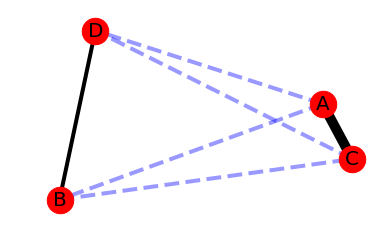

In [1043]:
%matplotlib inline
s.plot_graph()

## Fake data

In [1044]:
data = "sssmmmlllmlmlsslsllsmmllllmssssllllssmmlllllssssssmmmmsmllllssslmslmsmmmslsllll"""

In [1045]:
m = Markov_chain.from_sequence(data)

In [1058]:
m.transition_counts

array([[19,  5,  7],
       [ 6,  9,  5],
       [ 7,  6, 14]])

In [1048]:
m._prob_states

array([0.41, 0.25, 0.34])

In [1049]:
m.transition_freqs

array([[0.61, 0.16, 0.23],
       [0.3 , 0.45, 0.25],
       [0.26, 0.22, 0.52]])

In [1050]:
m.expected_freqs

array([[0.  , 0.39, 0.61],
       [0.62, 0.  , 0.38],
       [0.72, 0.28, 0.  ]])

In [1051]:
m.states

array(['l', 'm', 's'], dtype='<U1')

In [1052]:
m._conditional_probs('l')

array([0.61, 0.16, 0.23])

In [1053]:
m.generate_states(20)

['l',
 's',
 's',
 'm',
 'm',
 'm',
 'm',
 'l',
 'l',
 's',
 's',
 's',
 'l',
 'l',
 's',
 's',
 's',
 's',
 's',
 'l']